# TruthLens Modelling - Phase 1 : Binary Classification
The aim of phase 1 is to classify text into real or fake. "Fake" content will move to phase 2 for multiclass classification, so essentially what we are trying to do with this stage is to filter out real news.

The dataset used is the Misinformation & Fake News text dataset, which has already been cleaned and preprocessed (see "TruthLens Data Cleaning" notebook).

In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
import csv
import random
import pickle
import seaborn as sns
pd.set_option('display.max_colwidth', None)

### Feature Extraction Using TF-IDF, n-grams and readability metrics
In this section I will use a TfidfVectorizer to extract features from the training data. I will then combine these with the scaled readability metrics into one horizontally stacked feature matrix that I will use for modelling.

In [2]:
#load data
df = pd.read_csv('Data/phase1_final_clean.csv')
df = df.reset_index(drop=True)
print("Dataset Information:")
print(df.info(), "\n")
print("Dataset Head:")
print(df.head(3))

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78588 entries, 0 to 78587
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   content               78541 non-null  object 
 1   label                 78588 non-null  int64  
 2   word_count            78588 non-null  int64  
 3   sentence_count        78588 non-null  int64  
 4   flesch_reading_ease   78588 non-null  float64
 5   content_lemma         78540 non-null  object 
 6   content_lemma_nostop  78538 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 4.2+ MB
None 

Dataset Head:
                                                                                                                                                                                                                                                                                                                                         

In [13]:
#TF-IDF feature extraction with n-grams
start_time = time.time()
#replace NaN values with an empty string to resolve NaN ValueError
df['content_lemma_nostop'] = df['content_lemma_nostop'].fillna('')
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_tfidf = vectorizer.fit_transform(df['content_lemma_nostop'])
#get pre-calculated readability features
readability_features = df[['word_count', 'sentence_count', 'flesch_reading_ease']].values
#standardise readability features
scaler = StandardScaler()
readability_scaled = scaler.fit_transform(readability_features)
#convert to a sparse matrix
readability_sparse = csr_matrix(readability_scaled)
#combine TF-IDF features with the readability metrics
X_combined = hstack([X_tfidf, readability_sparse])

y = df['label']
print("Feature extraction: {:.4f} seconds".format(time.time() - start_time))

Feature extraction: 480.0830 seconds


### Split dataset

In [14]:
#retain the indices as we need these for looking up explanations later
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=999)
#split X and y using the train/test indices
X_train = X_combined[train_indices]
X_test = X_combined[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

### Phase 1 Modelling
I will test three different models on the data to see which is best. The models to be tested are:
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)

#### Logistic Regression

In [ ]:
start_time = time.time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Fit Logistic Regression model: {:.4f} seconds".format(time.time() - start_time))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fit Logistic Regression model: 6.0120 seconds
Accuracy: 0.942295457437333
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      6931
           1       0.94      0.95      0.95      8787

    accuracy                           0.94     15718
   macro avg       0.94      0.94      0.94     15718
weighted avg       0.94      0.94      0.94     15718



#### Random Forest

In [ ]:
start_time = time.time()
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Fit Random Forest model: {:.4f} seconds".format(time.time() - start_time))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))

Fit Random Forest model: 347.0968 seconds
Random Forest Accuracy: 0.9523476269245451
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      6931
           1       0.95      0.96      0.96      8787

    accuracy                           0.95     15718
   macro avg       0.95      0.95      0.95     15718
weighted avg       0.95      0.95      0.95     15718



#### Support Vector Machine (SVM)

In [ ]:
start_time = time.time()
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("Fit SVM model: {:.4f} seconds".format(time.time() - start_time))
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

Fit SVM model: 4252.7811 seconds
SVM Accuracy: 0.9504389871484922
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      6931
           1       0.95      0.96      0.96      8787

    accuracy                           0.95     15718
   macro avg       0.95      0.95      0.95     15718
weighted avg       0.95      0.95      0.95     15718



#### Conclusion
For phase 1 to be successful according to our success metrics, we want an accuracy of at least 90%. All three algorithms tested have performed better than that.

Random Forest and SVM both had an accuracy of 0.95 which is impressive. Logistic regression was slightly lower with an accuracy of 0.94. However, when computational efficiency is taken into account, Logistic regression is the preferred model. It took just over 6 seconds to fit the Logistic regression model to our data, compared to 347 seconds (almost 6 minutes) for random forest, and a whooping 4252 seconds (just under 71 minutes) for SVM.

Next we will test what column works best - content, content_lemma (which is lemmatised) or content_lemma_nostop (which is lemmatised and additionally has stopwords and punctuation removed.)

### Column selection

In [ ]:
def evaluate_text_representation(text_column, df):
    print("Evaluating model on ",text_column)
    start_time = time.time()
    #replace NaN values with an empty string to resolve NaN ValueError
    df[text_column] = df[text_column].fillna('')

    #get TF-IDF features for the chosen text column
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
    X_tfidf = vectorizer.fit_transform(df[text_column])

    #get pre-calculated readability features
    readability_features = df[['word_count', 'sentence_count', 'flesch_reading_ease']].values
    scaler = StandardScaler()
    #standardise readability features
    readability_scaled = scaler.fit_transform(readability_features)
    #convert to a sparse matrix
    readability_sparse = csr_matrix(readability_scaled)

    #combine TF-IDF features with the readability metrics
    X_combined = hstack([X_tfidf, readability_sparse])

    y = df['label']

    #split the data into training and testing sets using the dataframe index
    train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=999)
    X_train = X_combined[train_indices]
    X_test = X_combined[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    #train a simple Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    elapsed_time = time.time() - start_time

    # Evaluate and print the results
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Results for '{text_column}':")
    print("Time elapsed: {:.4f} seconds".format(elapsed_time))
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("-" * 50)

    return accuracy, model, vectorizer

In [ ]:
#columns to test
text_columns = ['content', 'content_lemma', 'content_lemma_nostop']
results = {}

#run the evaluation for each column
for col in text_columns:
    acc, model, vectorizer = evaluate_text_representation(col, df)
    results[col] = {'accuracy': acc, 'model': model, 'vectorizer': vectorizer}

#identify the best performing model based on accuracy
best_column = max(results, key=lambda x: results[x]['accuracy'])
best_result = results[best_column]

#print a summary of the accuracies
print("Summary of accuracies:")
for col, result in results.items():
    print(f"{col}: {result['accuracy']:.4f}")

print(f"\nBest performing column: {best_column} with accuracy: {best_result['accuracy']:.4f}")

#set the best model
best_model = best_result['model']

Evaluating model on  content
Results for 'content':
Time elapsed: 399.0861 seconds
Accuracy: 0.9401323323578064
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6931
           1       0.94      0.95      0.95      8787

    accuracy                           0.94     15718
   macro avg       0.94      0.94      0.94     15718
weighted avg       0.94      0.94      0.94     15718

--------------------------------------------------
Evaluating model on  content_lemma
Results for 'content_lemma':
Time elapsed: 355.7318 seconds
Accuracy: 0.9481486194172286
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      6931
           1       0.95      0.96      0.95      8787

    accuracy                           0.95     15718
   macro avg       0.95      0.95      0.95     15718
weighted avg       0.95      0.95      0.95     15718

-----------

#### Results
As we can see from the output above, the classifier performed best on the lemmatised column, with an accuracy of 0.9481.

Next we will use some tuning to try and increase the accuracy of our logistic regression model.

### Tweak model

In [6]:
#This code is repeated from the top of the file - look into making this a fucntion to reduce repetition
#Also I've just calculated most of this in the previous function - see if I can maybe get it from there instead of recalculating
start_time = time.time()
#replace NaN values with an empty string to resolve NaN ValueError
df['content_lemma'] = df['content_lemma'].fillna('')
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_tfidf = vectorizer.fit_transform(df['content_lemma'])
#get pre-calculated readability features
readability_features = df[['word_count', 'sentence_count', 'flesch_reading_ease']].values
#standardise readability features
scaler = StandardScaler()
readability_scaled = scaler.fit_transform(readability_features)
#convert to a sparse matrix
readability_sparse = csr_matrix(readability_scaled)
#combine TF-IDF features with the readability metrics
X_combined = hstack([X_tfidf, readability_sparse])

y = df['label']
print("Feature extraction: {:.4f} seconds".format(time.time() - start_time))



Feature extraction: 600.2935 seconds


In [7]:
#retain the indices as we need these for looking up explanations later
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=999)
#split X and y using the train/test indices
X_train = X_combined[train_indices]
X_test = X_combined[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

In [6]:
start_time = time.time()
#we're going to test for the best combo of regularisation type (l1 or l2), C values, and solvers
param_grid = [
    {
        #l1 regularisation
        'penalty': ['l1'],
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    },
    {
        #l2 regularization
        'penalty': ['l2'],
        'C': [0.1, 1, 10],
        'solver': ['saga', 'sag']
    }
]

#set up the grid search
grid = GridSearchCV(LogisticRegression(max_iter=2000), param_grid, cv=3, n_jobs = -1)
grid.fit(X_train, y_train)

#print the best parameters and best score, and the time it took
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)
print("Grid Search: {:.4f} seconds".format(time.time() - start_time))

Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.954254805167687
Grid Search: 15976.0700 seconds


#### Tuning Results
As we can see from the above results the best parameters chosen by the gridSearch were {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}. The best cross-validation score was 0.954 which is a big improvement from the previous score of 0.948 and our starting score of 0.942. The GridSearch is both computationally and time consuming, taking almost 4 and a half hours.


### Create and save final Phase 1 model

In [15]:
start_time = time.time()
#instantiate the final model with the best hyperparameters as found by the grid search
final_model = LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=2000)

#fit the model
final_model.fit(X_train, y_train)

#evaluate on the test set
final_predictions = final_model.predict(X_test)
final_probabilities = final_model.predict_proba(X_test)[:, 1]
print("Final Model Accuracy:", accuracy_score(y_test, final_predictions))
print("Final Model Classification Report:\n", classification_report(y_test, final_predictions))

print("Final model: {:.4f} seconds".format(time.time() - start_time))

Final Model Accuracy: 0.9470034355515969
Final Model Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      6931
           1       0.95      0.95      0.95      8787

    accuracy                           0.95     15718
   macro avg       0.95      0.95      0.95     15718
weighted avg       0.95      0.95      0.95     15718

Final model: 37.7171 seconds


In [16]:
#finally I want to test out the final model with just the TF-IDF features and not the readability features
start_time = time.time()

#fix nan error
df['content_lemma'] = df['content_lemma'].fillna('')
#TF-IDF feature extraction
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_tfidf = vectorizer_tfidf.fit_transform(df['content_lemma'])

#retain the indices as we need these for looking up explanations later
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=999)
#split X and y using the train/test indices
X_train_tfidf = X_tfidf[train_indices]
X_test_tfidf = X_tfidf[test_indices]
y_train_tfidf = y.iloc[train_indices]
y_test_tfidf = y.iloc[test_indices]

#instantiate the final model with the best hyperparameters as found by the grid search
final_model_tfidf = LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=2000)

#fit the model
final_model_tfidf.fit(X_train_tfidf, y_train_tfidf)

#evaluate on the test set
final_predictions_tfidf = final_model_tfidf.predict(X_test_tfidf)
final_probabilities_tfidf = final_model_tfidf.predict_proba(X_test_tfidf)[:, 1]
print("Final Model (TF-IDF) Accuracy:", accuracy_score(y_test_tfidf, final_predictions_tfidf))
print("Final Model (TF-IDF) Classification Report:\n", classification_report(y_test_tfidf, final_predictions_tfidf))

print("Final model (TF-IDF): {:.4f} seconds".format(time.time() - start_time))

Final Model (TF-IDF) Accuracy: 0.9535564321160453
Final Model (TF-IDF) Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      6931
           1       0.95      0.96      0.96      8787

    accuracy                           0.95     15718
   macro avg       0.95      0.95      0.95     15718
weighted avg       0.95      0.95      0.95     15718

Final model (TF-IDF): 704.6080 seconds


#### Conclusion:
Interestingly, we can see that the model trained without the readability metrics actually performs better (0.947 vs 0.953).  Will save out this model now. 

In [18]:
#save our model, vectorizer and scaler
with open('final_phase1_model.pkl', 'wb') as file:
    pickle.dump(final_model_tfidf, file)
with open('final_phase1_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer_tfidf, file)

### Model exploration
Now that we have saved out our final model, let's explore it a little further and examine the results more carefully. We'll look at the confusion matrix and ROC curve, and look at some examples of misclassified rows so we can see if we can see any trend or issue.

Confusion Matrix:
[[6529  402]
 [ 328 8459]]


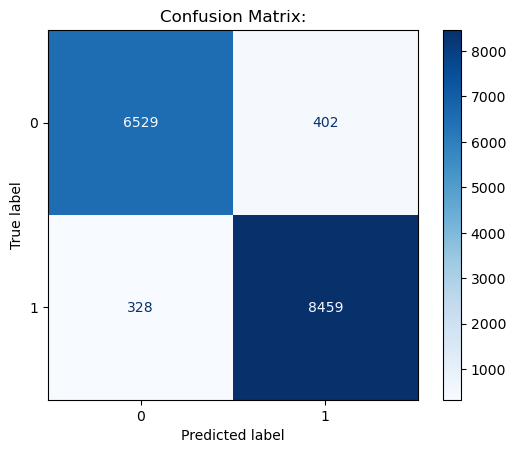

In [19]:
#calculate the confusion matrix
cm = confusion_matrix(y_test_tfidf, final_predictions_tfidf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix:")
plt.show()

In [20]:
test_df = df.iloc[test_indices].copy()
test_df['actual_label'] = y_test_tfidf.values
test_df['predicted_label'] = final_predictions_tfidf

#filter for just incorrectly classified rows
misclassified = test_df[test_df['actual_label'] != test_df['predicted_label']]
print("Number of misclassified examples:", len(misclassified))

#show some misclassified examples
print(misclassified[['content', 'actual_label', 'predicted_label']].head())

Number of misclassified examples: 730
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

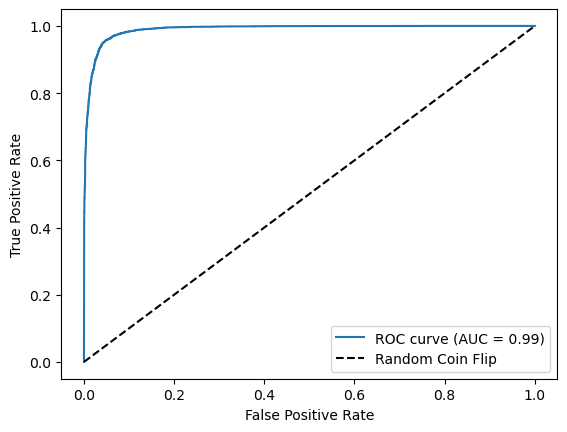

In [21]:
fpr, tpr, thresholds = roc_curve(y_test_tfidf, final_probabilities_tfidf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Coin Flip')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


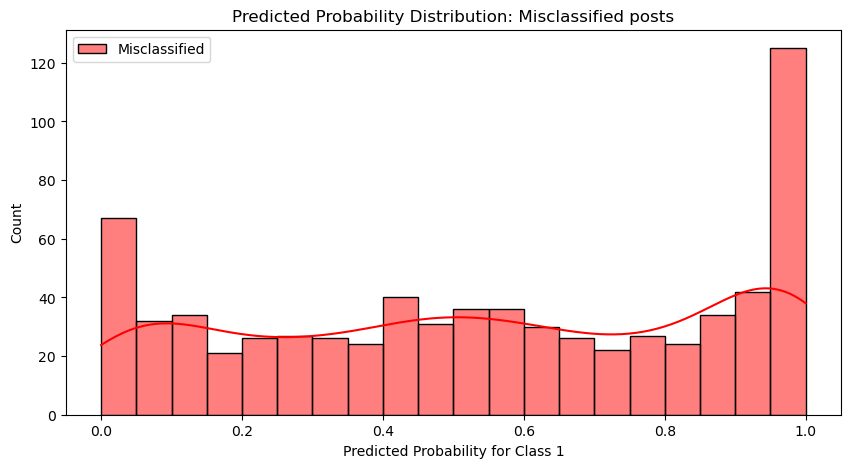

In [22]:
#add predicted probability to the test df
test_df['predicted_probability'] = final_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

#separate out incorrectly classified examples
misclassified = test_df[test_df['actual_label'] != test_df['predicted_label']]

#plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(misclassified['predicted_probability'], bins=20, color='red', label='Misclassified', kde=True)
plt.xlabel("Predicted Probability for Class 1")
plt.title("Predicted Probability Distribution: Misclassified posts")
plt.legend()
plt.show()

Charting this is interesting because we can learn a few things.

Firstly, there is a spike of misclassified examples with a predicted probability near 1.0. This means the model is very certain that they belong to class 1 (Fake) but they are actually true. High confidence errors like this can be an indication of overfitting, or learning spurious signals. We see a similar but smaller spike at 0.0. 

Secondly, there are quite a few misclassifications in the middle range where the predication probability is between 0.4 and 0.6. These errors are more expected and could be migitated somewhat by adjusting the decision threshold.

In [23]:
#define thresholds
high_threshold = 0.85
low_threshold = 0.25

high_confidence_class1_errors = misclassified[(misclassified['predicted_label'] == 1) & (misclassified['predicted_probability'] >= high_threshold)]
high_confidence_class0_errors = misclassified[(misclassified['predicted_label'] == 0) & (misclassified['predicted_probability'] <= low_threshold)]

#print examples from each
print("High confidence errors predicted as class 1 (Fake):")
print(high_confidence_class1_errors[['content', 'actual_label', 'predicted_label', 'predicted_probability']].head(3))

print("\nHigh confidence errors predicted as class 0 (True):")
print(high_confidence_class0_errors[['content', 'actual_label', 'predicted_label', 'predicted_probability']].head(3))

High confidence errors predicted as class 1 (Fake):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    